<a href="https://colab.research.google.com/github/LadaChernenko/bird_species_guide/blob/class/bird_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bird species image classification

In [21]:
!pip install efficientnet_pytorch

In [22]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
from efficientnet_pytorch import EfficientNet
import time

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


В задаче классификации участвовали фотографии 20 классов (фотографии были собраны из google images по английским названиям.

In [26]:
BATCH_SIZE = 50
n_epochs = 10

## 1 Classification

### 1.1 Dataset & dataloader

Фотографии находятся в папках своего класса без разделения на тестовую и обучающую выборки.

In [27]:
img_path = './bird_dataset/bird_img' # путь до папки с датасетом

In [28]:
labels = sorted(os.listdir(img_path))
label_dict = {i:labels[i] for i in range(0, len(labels))}
num_classes = len(label_dict)

In [29]:
label_dict

{0: 'black_kite',
 1: 'chaffinch',
 2: 'common_magpie',
 3: 'common_raven',
 4: 'crested_tit',
 5: 'eurasian_jay',
 6: 'eurasian_pygmy-owl',
 7: 'eurasian_tree_sparrow',
 8: 'european_turtle-dove',
 9: 'great_spotted_woodpecker',
 10: 'hazel_grouse',
 11: 'northern_harrier',
 12: 'rock_pigeon',
 13: 'ruddy_shelduck',
 14: 'snow_goose',
 15: 'snowy_owl',
 16: 'waxwing',
 17: 'white_stork',
 18: 'white_wagtail',
 19: 'willow_grouse'}

In [30]:
class BirdDataset(Dataset):
    def __init__(self, img_folder, img_size):
      
        super().__init__()
        self.img_folder = img_folder
    
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize(img_size),
                                        transforms.RandomAutocontrast(p=0.3),
                                        transforms.GaussianBlur(1, sigma=(0.1, 0.2)),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])
     
        self.dataset = datasets.ImageFolder(self.img_folder, transform=transform)

    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):  
        img_tensor = self.dataset[idx][0]
        object_label = self.dataset[idx][1]

        return {'image': img_tensor, 'label': object_label}

In [31]:
bird_set = BirdDataset(img_path,[256, 256])

In [32]:
len(bird_set)

5434

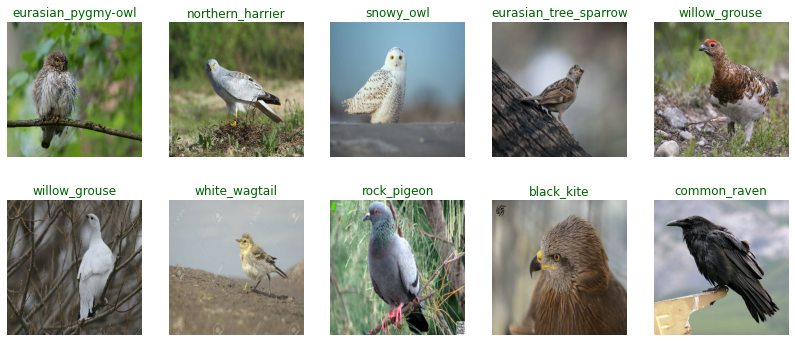

In [33]:
def show_img_n_lbl(data_set, is_labels_pred=False):

    f, axes = plt.subplots(2,5, figsize=(14, 6))
    for i in range(2):
        for p in range(5):
            idx = np.random.randint(0, len(data_set))
            img_tensor = data_set[idx]['image']
            label = data_set[idx]['label']
            image = np.moveaxis(img_tensor.numpy(), 0, 2)
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            im_lb = label_dict[label]
            if is_labels_pred == True:
                with torch.no_grad():
                    label_pred = model(torch.unsqueeze(img, dim=0).to(device)).cpu().numpy()[0].argmax()
                pred_im_lb = label_dict[label_pred]
                axes[i][p].suptitle(pred_im_lb, color='darkred', fontsize=12)

            axes[i][p].axis('off')
            axes[i][p].imshow(image.clip(0, 1))
            axes[i][p].set_title(im_lb, color='darkgreen', fontsize=12)


show_img_n_lbl(bird_set, is_labels_pred=False)

#### 1.1.1 Train & val split 

In [35]:
# train/val split 
train_size = int(0.8 * len(bird_set))
val_size = len(bird_set) - train_size
train_set, val_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, val_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [36]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 1.2 Network architecture

В качестве модели использовалась предобученная [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load('./efficientnet-b0-08094119.pth'))   # from https://www.kaggle.com/hmendonca/efficientnet-pytorch
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [38]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [39]:
def train_epoch(loader, optimizer):

    model.train()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in loader:
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Train: {epoch_loss / len(loader)} | acc: {correct / total}')
    return epoch_loss

  
def val_epoch(loader, optimizer):

    model.eval()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in loader:
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        with torch.no_grad():
            loss = loss_function(predictions, labels)
            
        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(loader)} | acc: {correct / total}')
    return epoch_loss

In [40]:
start = time.time()
for epoch in range(n_epochs):

    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    train_loss = train_epoch(train_loader, optimizer)
    val_loss = val_epoch(val_loader, optimizer)
end = time.time()
print('Time: {}'.format(end - start))

Epoch 1/10
Train: 2.1906922034833625 | acc: 0.5962733030319214


RuntimeError: ignored

### 2.2  Network architecture

In [ ]:
# for sample in test_set:
#     if sample['label'] == 10:
#         image = sample['image']
#         label = sample['label']
#         break
#sample = test_set[350] 

# with torch.no_grad():
#     label_pred = model(torch.unsqueeze(image, dim=0).to(device)).cpu().numpy()[0].argmax()
show_img_n_lbl(val_set, is_label_pred=True)